In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
df = pd.read_csv('Historical Product Demand.csv')
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


### Data Explore

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


###  Data Cleaning

In [38]:
# Remove parentheses and convert to float
df['Order_Demand'] = df['Order_Demand'].str.replace(r'[()]', '', regex=True).astype(float)


In [39]:
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')
df['Order_Demand'].isna().sum()


np.int64(0)

In [40]:
df.isna().sum()


Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [41]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df['Month'] = df['Date'].dt.month



C:\Users\Ismat\AppData\Local\Temp\ipykernel_16364\3877424758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date'].dt.month


In [42]:
df.isna().sum()


Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
Month               0
dtype: int64

In [43]:
df = df.drop(columns=['Date','Product_Code'])

In [44]:
df

,Warehouse,Product_Category,Order_Demand,Month
0,Whse_J,Category_028,100.0,7
1,Whse_J,Category_028,500.0,1
2,Whse_J,Category_028,500.0,2
3,Whse_J,Category_028,500.0,2
4,Whse_J,Category_028,500.0,3
...,...,...,...,...
1048570,Whse_J,Category_006,1000.0,4
1048571,Whse_J,Category_006,1.0,4
1048572,Whse_J,Category_006,2500.0,4
1048573,Whse_J,Category_023,50.0,10


## EDA

In [45]:
print(df.describe(include='all'))  # include categorical summary
df.info()

       Warehouse Product_Category  Order_Demand         Month
count    1037336          1037336  1.037336e+06  1.037336e+06
unique         4               33           NaN           NaN
top       Whse_J     Category_019           NaN           NaN
freq      764447           470266           NaN           NaN
mean         NaN              NaN  4.949384e+03  6.507711e+00
std          NaN              NaN  2.907344e+04  3.446122e+00
min          NaN              NaN  0.000000e+00  1.000000e+00
25%          NaN              NaN  2.000000e+01  3.000000e+00
50%          NaN              NaN  3.000000e+02  7.000000e+00
75%          NaN              NaN  2.000000e+03  1.000000e+01
max          NaN              NaN  4.000000e+06  1.200000e+01
<class 'pandas.core.frame.DataFrame'>
Index: 1037336 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Warehouse         1037336 non-null  object 
 1

#### Categorical columns distribution

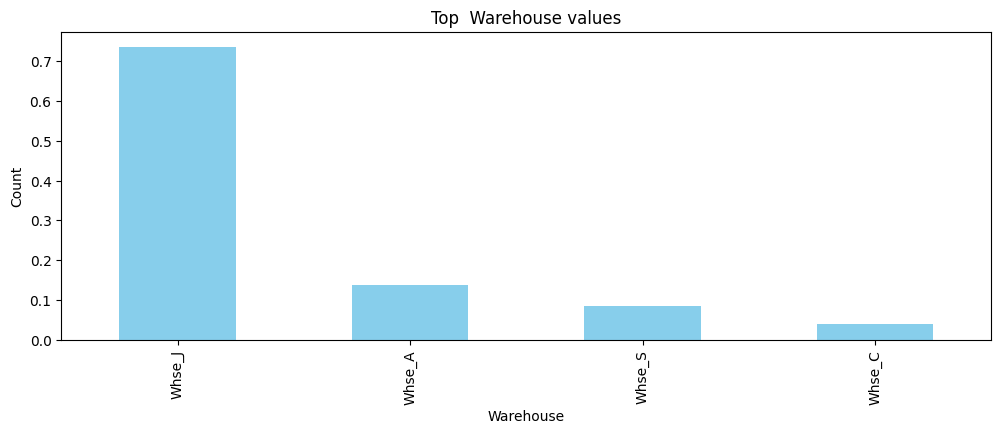

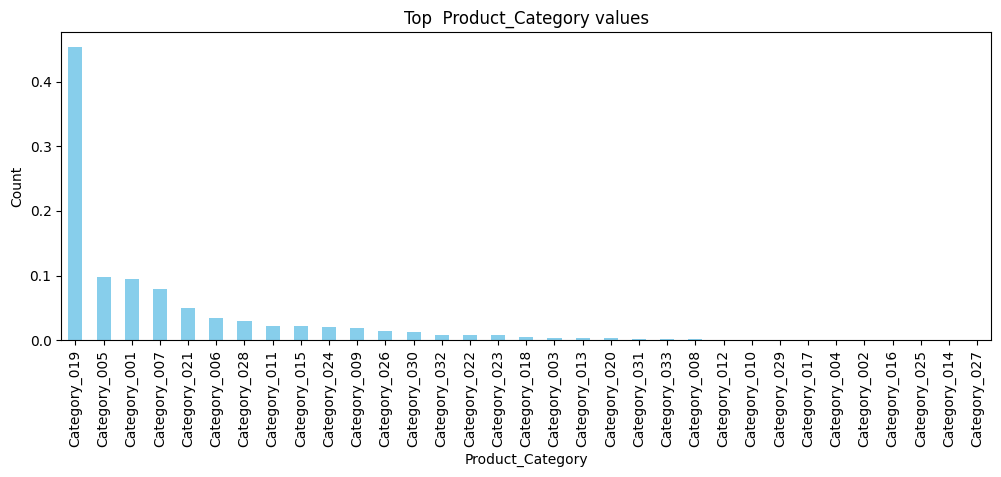

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.iloc[:,0:2]
for col in categorical_cols:
    plt.figure(figsize=(12,4))
    df[col].value_counts(20).plot(kind='bar', color='skyblue')
    plt.title(f"Top  {col} values")
    plt.ylabel('Count')
    plt.show()


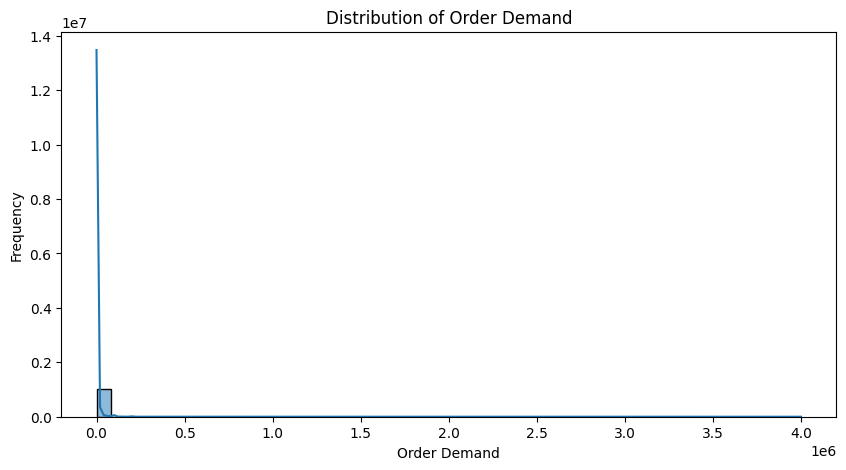

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df["Order_Demand"], kde=True, bins=50)
plt.title("Distribution of Order Demand")
plt.xlabel("Order Demand")
plt.ylabel("Frequency")
plt.show()


Demand_Range
0-500        603298
501-1000     132013
1001-5000    164668
5001-10k      63007
10k-20k       30609
20k-50k       29245
50k-100k       8974
100k+          5522
Name: count, dtype: int64

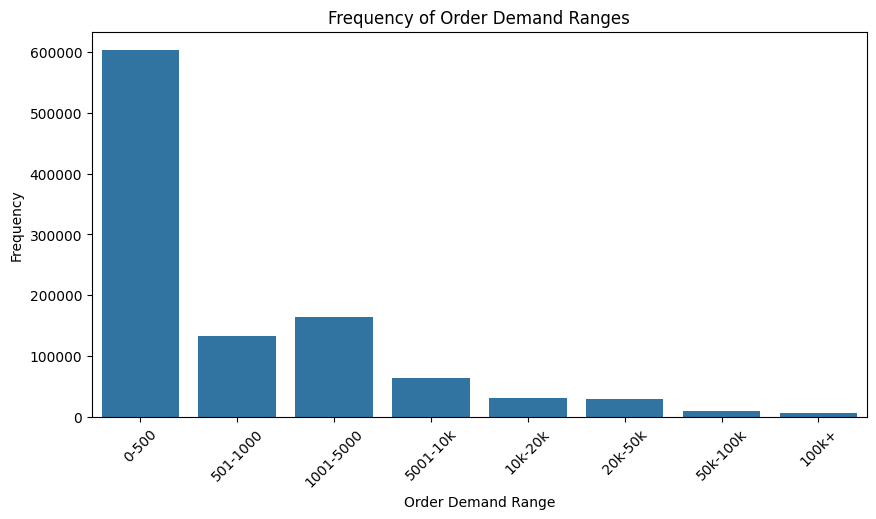

In [48]:
import pandas as pd

bins = [0, 500, 1000, 5000, 10000, 20000, 50000, 100000, df["Order_Demand"].max()]
labels = [
    "0-500", "501-1000", "1001-5000", "5001-10k", 
    "10k-20k", "20k-50k", "50k-100k", "100k+"
]

df["Demand_Range"] = pd.cut(df["Order_Demand"], bins=bins, labels=labels, include_lowest=True)

freq_table = df["Demand_Range"].value_counts().sort_index()
display(freq_table)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=freq_table.index, y=freq_table.values)
plt.title("Frequency of Order Demand Ranges")
plt.xlabel("Order Demand Range")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


##### It is a highly skewed distribution, has a long right tail, which is common in demand dataset. 
##### We may need to consider log transformation or scaling for modeling regression. 
##### A log-scaled histogram to show the long-tail nature

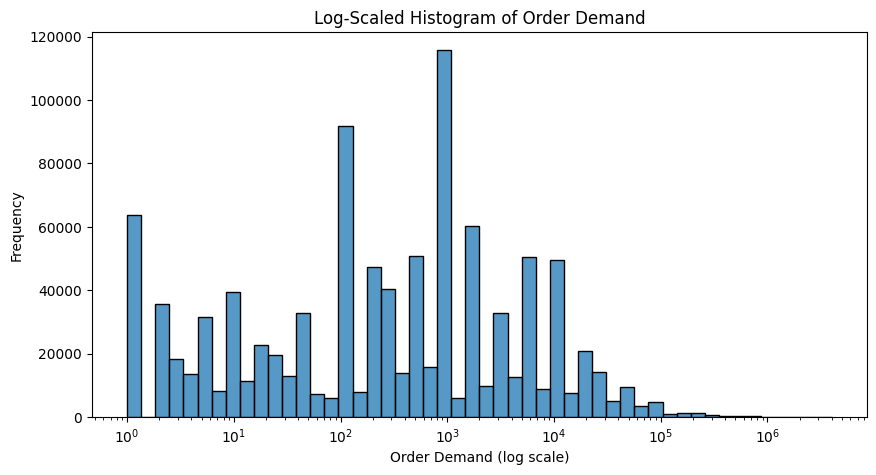

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,5))
sns.histplot(df["Order_Demand"], bins=50, log_scale=(True, False))  # log scale for x-axis
plt.title("Log-Scaled Histogram of Order Demand")
plt.xlabel("Order Demand (log scale)")
plt.ylabel("Frequency")
plt.show()


C:\Users\Ismat\AppData\Local\Temp\ipykernel_16364\2322412618.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Order_Demand', data=monthly_demand, palette='Greens')  # Use valid palette


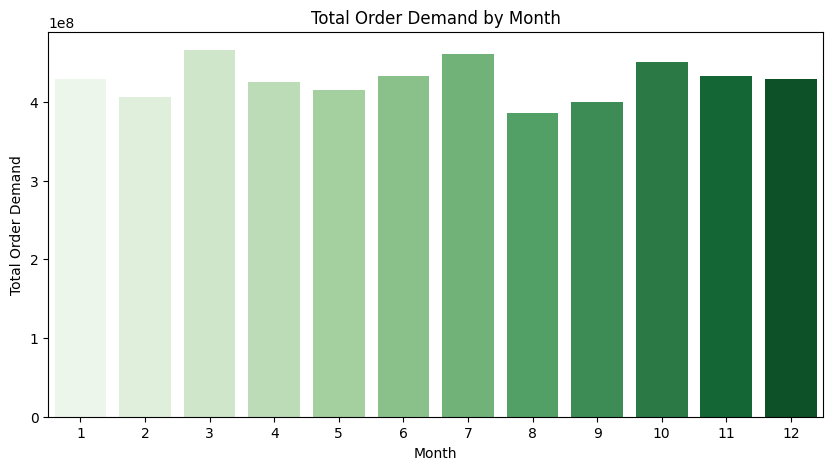

In [50]:

import matplotlib.pyplot as plt
import seaborn as sns

# Total demand by month
monthly_demand = df.groupby('Month')['Order_Demand'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='Month', y='Order_Demand', data=monthly_demand, palette='Greens')  # Use valid palette
plt.title("Total Order Demand by Month")
plt.xlabel("Month")
plt.ylabel("Total Order Demand")
plt.show()



####  Select features and target
##### For Target, we are applying a log transformation so that it can handle heavily skewed data


In [ ]:
import numpy as np
# Select features and target
X = df[['Warehouse', 'Product_Category', 'Month']]
y = np.log1p(df['Order_Demand'])  # log(1 + x) to handle zeros

# Label encode Warehouse and Product_Category for tree-based models
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
for col in ['Warehouse', 'Product_Category']:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])

In [51]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Select features and target
X = df[['Warehouse', 'Product_Category', 'Month']]
y = np.log1p(df['Order_Demand'])  # log(1 + x) to handle zeros

# Label encode categorical features
X_encoded = X.copy()
for col in ['Warehouse', 'Product_Category']:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])

# Scale all features (including Month and encoded categorical)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Now X_scaled is ready to be used for modeling


#### Split data (only on 1% of data for optimizing parameters)

In [52]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Split data
#X_train, X_test, y_train, y_test = train_test_split(
    #X_encoded, y, test_size=0.2, random_state=42
#)
sample_frac = 0.01  # 1% of data
X_small = X_scaled.sample(frac=sample_frac, random_state=42)
y_small = y.sample(frac=sample_frac, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)


AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [53]:
import numpy as np

sample_frac = 0.01
n_samples = int(X_scaled.shape[0] * sample_frac)
indices = np.random.choice(X_scaled.shape[0], n_samples, replace=False)

X_small = X_scaled[indices]
y_small = y.to_numpy()[indices]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)



### SVR with optimization

In [54]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Define SVR hyperparameter space
param_dist = {
    'C': [0.1, 1, 10, 50, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'kernel': ['linear', 'rbf']
}

# Initialize SVR
svr = SVR()

# Randomized Search CV
random_search = RandomizedSearchCV(
    svr,
    param_distributions=param_dist,
    n_iter=10,     # number of random combinations
    cv=2,          # 2-fold CV for speed
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Predict on test set
y_pred = random_search.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
score_svr = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {score_svr}")


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters: {'kernel': 'rbf', 'epsilon': 1.0, 'C': 100}
Mean Squared Error: 5.0759599508629085
Mean Absolute Error: 1.7420413476758116
R² Score: 0.4114060907153906


#### Decision Tree

In [55]:
# Do a Decision Tree regressor analysis

modelTree = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
y_pred = modelTree.predict(X_test) 

scoreDT=modelTree.score(X_test, y_test)
print(scoreDT)

0.5340874020661066


### Parameter tuning for Decision Tree

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define hyperparameter space
param_dist = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["squared_error", "absolute_error"]
}

# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=50,        # fewer iterations for speed
    cv=3,             # 2-fold CV for faster computation
    scoring="r2",
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Predict on test set
y_pred = random_search.predict(X_test) 

scoreDT=random_search.score(X_test, y_test)
print(scoreDT)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'squared_error'}
0.5497242963147849


#### Random Forest

In [57]:
 # Random Forest Regressor analysis
from sklearn.ensemble import RandomForestRegressor

score=[]
estimator_num=[]
temp_score = []

for estimators in range (1,21,1):
    
    estimator_num.append(estimators)
    modelRandFor = RandomForestRegressor(n_estimators = estimators, 
                                         random_state = 0).fit(X_train,
                                                               y_train)
    y_predRF = modelRandFor.predict(X_test)
    
    score = (modelRandFor.score(X_test, y_test))
    temp_score.append(score)

    print(estimators,'estimators gives a score of:',modelRandFor.score(X_test, y_test))

scoreRF = max(temp_score)
print('Random Forest Maximum Score is:',scoreRF)

1 estimators gives a score of: 0.5123872647627545
2 estimators gives a score of: 0.5286767541607664
3 estimators gives a score of: 0.5324083871294535
4 estimators gives a score of: 0.5338134570767102
5 estimators gives a score of: 0.5344459611268888
6 estimators gives a score of: 0.5361142307427101
7 estimators gives a score of: 0.5375148239102292
8 estimators gives a score of: 0.5380705425754588
9 estimators gives a score of: 0.5380843293716218
10 estimators gives a score of: 0.5382398577225673
11 estimators gives a score of: 0.5385225396166449
12 estimators gives a score of: 0.5385626902434708
13 estimators gives a score of: 0.5383933535926821
14 estimators gives a score of: 0.5382269390436015
15 estimators gives a score of: 0.5381709163069849
16 estimators gives a score of: 0.538447057030844
17 estimators gives a score of: 0.5388644927960331
18 estimators gives a score of: 0.5385866152028393
19 estimators gives a score of: 0.5394085378836023
20 estimators gives a score of: 0.5392732

#### Parameter tuning for Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200],                  # fewer trees for tuning
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized Search CV
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,       # random combinations, keep small for speed
    cv=3,            # 2-fold CV for faster computation
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Predict on test set
y_pred = random_search.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'squared_error'}
Mean Squared Error: 3.7940969890963308
Mean Absolute Error: 1.4742795124201737
R² Score: 0.5514937549614545


### Use the best parameter from the optimization for full data

In [58]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [59]:
from sklearn.neighbors import KNeighborsRegressor
# Initialize KNN with best parameters
knn_full = KNeighborsRegressor(
    n_neighbors=15,
    weights='uniform',
    p=1,
    n_jobs=-1  # use all CPU cores
)

# Fit on full dataset
score_knn1 = knn_full.fit(X_train, y_train)
y_pred = knn_full.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

score_knn1 = knn_full.score(X_test,y_test)
print(mse)
print(score_knn1)

4.080643031769911
0.526967286572844


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize Random Forest with best parameters
rf_full = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features=None,
    criterion='squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rf_full.fit(X_train, y_train)

# Predict on test set
y_pred = rf_full.predict(X_test)

# Evaluate
mse_rf1 = mean_squared_error(y_test, y_pred)

score_rf1 = rf_full.score(X_test,y_test)
print(mse_rf1)
print(score_rf1)

3.8603439535928854
0.5525046026047198


In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize Decision Tree with best parameters
dt_full = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=10,
    criterion='squared_error',
    random_state=42
)

# Fit on training data
dt_full.fit(X_train, y_train)

# Predict on test set
y_pred = dt_full.predict(X_test)

# Evaluate
score_dt1 = dt_full.score(X_test, y_test)  # R²
mse_dt1 = mean_squared_error(y_test, y_pred)
mae_dt1 = mean_absolute_error(y_test, y_pred)

print(f"Decision Tree R² Score: {score_dt1}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Decision Tree R² Score: 0.5524331859311684
Mean Squared Error: 4.080643031769911
Mean Absolute Error: 1.7420413476758116


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize SVR with best parameters
svr_best = SVR(
    kernel='rbf',
    epsilon=1.0,
    C=100,
    gamma='scale'
)

# Fit on training data
svr_best.fit(X_train, y_train)

# Predict on test set
y_pred_svr = svr_best.predict(X_test)

# Evaluate
score_svr1 = r2_score(y_test, y_pred_svr)     # R²
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

print(f"SVR (Best Params) R² Score: {score_svr1}")
print(f"Mean Squared Error: {mse_svr}")
print(f"Mean Absolute Error: {mae_svr}")


C:\Users\Ismat\AppData\Local\Temp\ipykernel_16364\3134254632.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(model_names), ax1.set_ylabel('Method'), ax1.set_xlabel('Accuracy Score')


Text(0.5, 1.0, 'Variation of order demand by ML Method')

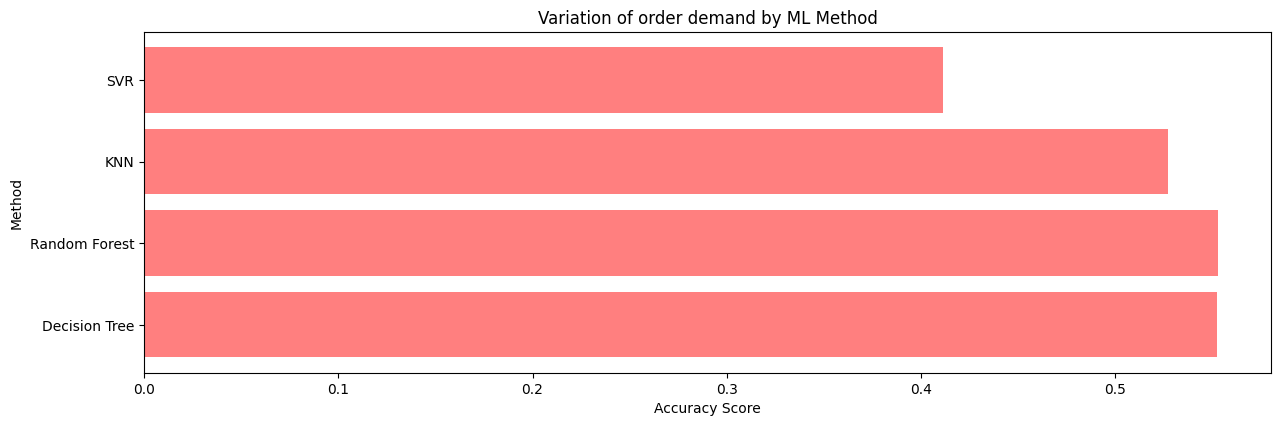

In [ ]:
import numpy as np
# Store all the model names and scores in lists to plot
model_names = ['Decision Tree',
               'Random Forest','KNN','SVR']
y_pos = np.arange(len(model_names))
model_scores = [score_dt1,score_rf1,score_knn1,score_svr1]

fig3, (ax1) = plt.subplots(figsize=(12,4))
fig3.tight_layout()

# Plot all method scores
ax1.barh(model_names,model_scores, align='center', alpha=0.5,color='red')
ax1.set_yticklabels(model_names), ax1.set_ylabel('Method'), ax1.set_xlabel('Accuracy Score')
ax1.set_title('Variation of order demand by ML Method')
